<a href="https://colab.research.google.com/github/xavyeerx/Sentimen-Analisis-E-Commerce/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setting the environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow

In [ ]:
# Importing essential libraries and functions

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
import tensorflow as tf

In [ ]:
pip install keras

In [ ]:
from keras.preprocessing.text import one_hot, Tokenizer
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense, Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

In [ ]:
pip install keras-preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.8 MB/s eta 0:00:00


In [ ]:
from keras_preprocessing.sequence import pad_sequences

## Loading dataset

In [ ]:
# Importing IMDb Movie Reviews dataset

data = pd.read_csv("/content/drive/MyDrive/Machine Learning/Lazada/ecommerce.csv")

# dataset source: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [ ]:
# Dataset exploration
data.shape

(110110, 2)

In [ ]:
data.head(5)

,reviewContent,rating
0,bagus mantap dah sesui pesanan,5
1,"Bagus, sesuai foto",4
2,okkkkk mantaaaaaaapppp ... goood,5
3,bagus sesuai,4
4,bima,1


In [ ]:
# Checking for missing values

data.isnull().values.any()

False

In [ ]:
# Menghitung jumlah kemunculan setiap nilai dalam kolom 'rating'
rating_counts = data['rating'].value_counts().sort_index()

# Menampilkan hasil
print(rating_counts)


rating
1     7628
2     2628
3     6332
4    10626
5    82896
Name: count, dtype: int64


In [ ]:
# Membuat kolom baru 'sentimen' berdasarkan kolom 'rating'
data['sentimen'] = data['rating'].apply(lambda x: 'negatif' if x in [1, 2, 3] else 'positif')

# Menampilkan data
print(data.head())

                      reviewContent  rating sentimen
0   bagus  mantap dah sesui pesanan       5  positif
1                Bagus, sesuai foto       4  positif
2  okkkkk mantaaaaaaapppp ... goood       5  positif
3                      bagus sesuai       4  positif
4                              bima       1  negatif


In [ ]:
data['sentimen'].value_counts()

sentimen
positif    93522
negatif    16588
Name: count, dtype: int64

<Axes: xlabel='sentimen', ylabel='count'>

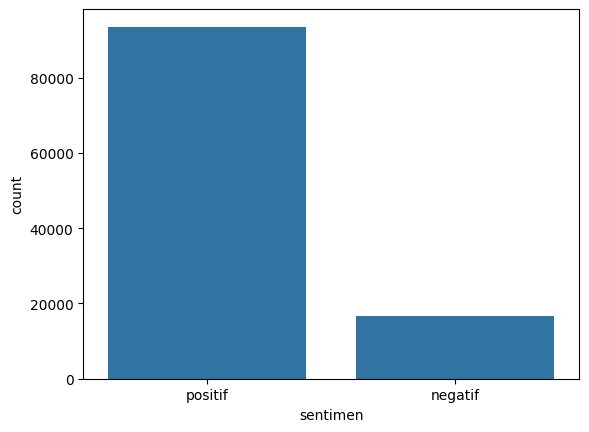

In [ ]:
import seaborn as sns
sns.countplot(x='sentimen', data=data)

In [ ]:
# Pisahkan data positif
positif = data[data['sentimen'] == 'positif']

# Ambil sampel acak dari data positif sebanyak 70 ribu
positif_sample_to_drop = positif.sample(n=30000, random_state=42)

# Hapus data tersebut dari DataFrame asli
data_filter = data.drop(positif_sample_to_drop.index)

# Opsional: Reset index jika diperlukan
data_filter = data_filter.reset_index(drop=True)

# Simpan kembali ke file jika diperlukan
# data_filter.to_csv('data_filtered.csv', index=False)

print(data_filter['sentimen'].value_counts())

sentimen
positif    63522
negatif    16588
Name: count, dtype: int64


<Axes: xlabel='sentimen', ylabel='count'>

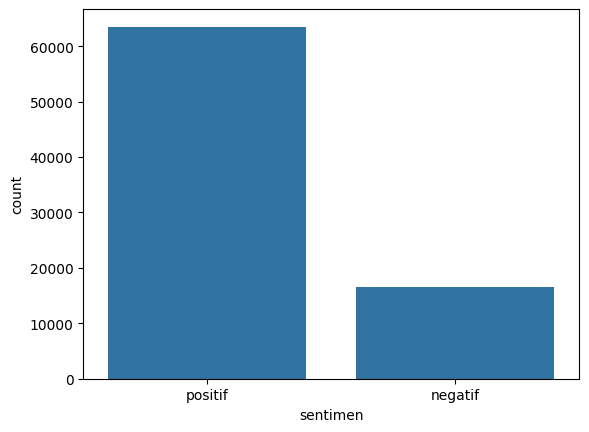

In [ ]:
import seaborn as sns
sns.countplot(x='sentimen', data=data_filter)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn import svm
from sklearn.metrics import classification_report

# Sentimen yang ada pada seluruh data train dapat dilihat dengan memahami kata yang umum dengan plot word cloud
def wordCloud(words):
    wordCloud = WordCloud(width=800, height=500, background_color='white', random_state=21, max_font_size=120).generate(words)

    plt.figure(figsize=(10, 7))
    plt.imshow(wordCloud, interpolation='bilinear')
    plt.axis('off')

all_words = ' '.join([text for text in data['reviewContent']])
wordCloud(all_words)

In [ ]:
# Melihat kata-kata yang negatif
negative_words = ' '.join(text for text in data_filter['reviewContent'][data_filter['sentimen'] == 'negatif'])
wordCloud(negative_words)

In [ ]:
# Melihat kata-kata yang positif
negative_words = ' '.join(text for text in data_filter['reviewContent'][data_filter['sentimen'] == 'positif'])
wordCloud(negative_words)

## Data Preprocessing

In [ ]:
data_filter["reviewContent"][120]

# You can see that our reviewContent contains punctuations, brackets, HTML tags and numbers
# We will preprocess this reviewContent in the next section

In [ ]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

In [ ]:
import nltk
nltk.download('stopwords')

In [ ]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''

    sentence = sen.lower()
    # Remove html tags
    sentence = remove_tags(sentence)
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.
    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.
    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('indonesian')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [ ]:
# Mengimpor kelas CustomPreprocess dari modul b2_preprocessing_function
from b2_preprocessing_function import CustomPreprocess

In [ ]:
# Menginisialisasi objek dari kelas CustomPreprocess
custom = CustomPreprocess()

In [ ]:
# Calling preprocessing_text function on data

X = []
sentences = list(data_filter['reviewContent'])
for sen in sentences:
    X.append(custom.preprocess_text(sen))

In [ ]:
# Sample cleaned up movie review
X[0:10]

In [ ]:
# Mengonversi nilai 'sentimen' menjadi 0 hingga 4
y = data_filter['sentimen'].apply(lambda x: 1 if x == 'positif' else 0)
# Mengonversi ke array numpy
y = np.array(y)

In [ ]:
print(y)

In [ ]:
data_filter.head(10)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# The train set will be used to train our deep learning models
# while test set will be used to evaluate how well our model performs

## Preparing embedding layer

Let's now write the script for our embedding layer. Embedding layer converts our textual data into numeric form. It is then **used as the first layer for the deep learning models in Keras**.

In [ ]:
# Embedding layer expects the words to be in numeric form
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer
# Method texts_to_sequences converts sentences to their numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [ ]:
import io
import json

tokenizer_json = word_tokenizer.to_json()
with io.open('b3_tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [ ]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

17587

In [ ]:
# Padding all reviews to fixed length 100

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('a2_glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
# Create Embedding Matrix having 100 columns
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
embedding_matrix.shape

(17587, 100)

# Model Training with:

## Convolutional Neural Network

In [ ]:
from keras.layers import Conv1D
from keras.callbacks import EarlyStopping

In [ ]:
# Neural Network architecture
cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Model compiling
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          1758700   
                                                                 
 conv1d_2 (Conv1D)           (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d_2 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1822957 (6.95 MB)
Trainable params: 64257 (251.00 KB)
Non-trainable params: 1758700 (6.71 MB)
_________________________________________________________________
None


In [ ]:
# Adding EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

# Model training
cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.4, callbacks=[early_stopping])

Epoch 1/12
217/217 [==============================] - 23s 100ms/step - loss: 0.4222 - acc: 0.8215 - val_loss: 0.3811 - val_acc: 0.8375
Epoch 2/12
217/217 [==============================] - 21s 97ms/step - loss: 0.3402 - acc: 0.8643 - val_loss: 0.3532 - val_acc: 0.8525
Epoch 3/12
217/217 [==============================] - 22s 103ms/step - loss: 0.2942 - acc: 0.8913 - val_loss: 0.3295 - val_acc: 0.8685
Epoch 4/12
217/217 [==============================] - 27s 123ms/step - loss: 0.2582 - acc: 0.9091 - val_loss: 0.3290 - val_acc: 0.8708
Epoch 5/12
217/217 [==============================] - 23s 108ms/step - loss: 0.2271 - acc: 0.9261 - val_loss: 0.3095 - val_acc: 0.8824
Epoch 6/12
217/217 [==============================] - 23s 106ms/step - loss: 0.2009 - acc: 0.9362 - val_loss: 0.3066 - val_acc: 0.8838
Epoch 7/12
217/217 [==============================] - 21s 97ms/step - loss: 0.1803 - acc: 0.9450 - val_loss: 0.3042 - val_acc: 0.8893
Epoch 8/12
217/217 [==============================] - 21s

In [ ]:
# Predictions on the Test Set

score = cnn_model.evaluate(X_test, y_test, verbose=1)

964/964 [==============================] - 9s 10ms/step - loss: 0.3299 - acc: 0.8867


In [ ]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.32986360788345337
Test Accuracy: 0.8867202401161194


964/964 [==============================] - 9s 9ms/step


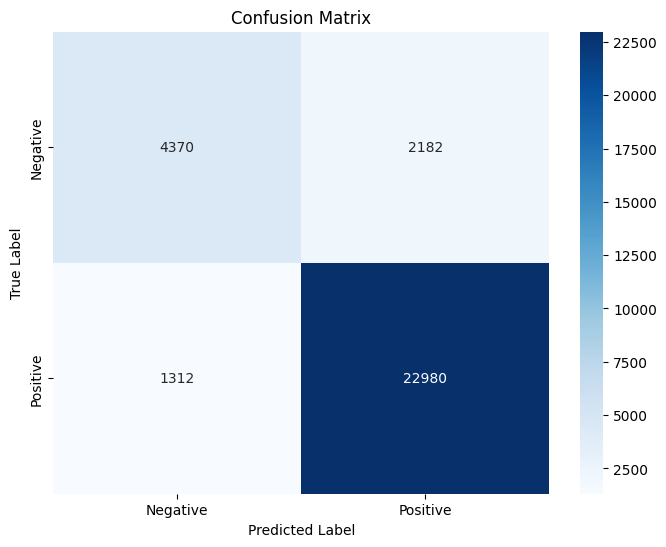

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Predict using the trained model
y_pred_probs = cnn_model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import numpy as np
from keras.preprocessing.sequence import pad_sequences

# Function to preprocess the input text
def preprocess_input_text(text, tokenizer, maxlen):
    # Convert text to sequence of tokens
    sequence = tokenizer.texts_to_sequences([text])
    # Pad the sequence
    padded_sequence = pad_sequences(sequence, padding='post', maxlen=maxlen)
    return padded_sequence

# Function to predict sentiment
def predict_sentiment(text, model, tokenizer, maxlen):
    # Preprocess the text
    processed_text = preprocess_input_text(text, tokenizer, maxlen)
    # Make prediction
    prediction = model.predict(processed_text)
    # Return sentiment
    if prediction >= 0.5:
        return "positif"
    else:
        return "negatif"

# Example usage
input_text = "awalnya ragu buat beli tapi pas sampai barangnya sangat memuaskan"
predicted_sentiment = predict_sentiment(input_text, cnn_model, word_tokenizer, maxlen)
print(f"Sentiment of the input text is: {predicted_sentiment}")

1/1 [==============================] - 0s 19ms/step
Sentiment of the input text is: positif


In [ ]:
# Example usage
input_text = "kecewa sama penjualnya karena barang yang sampai ga sesuai"
predicted_sentiment = predict_sentiment(input_text, cnn_model, word_tokenizer, maxlen)
print(f"Sentiment of the input text is: {predicted_sentiment}")

1/1 [==============================] - 0s 213ms/step
Sentiment of the input text is: negatif


In [ ]:
# Example usage
input_text = "jangan beli barang di toko ini"
predicted_sentiment = predict_sentiment(input_text, cnn_model, word_tokenizer, maxlen)
print(f"Sentiment of the input text is: {predicted_sentiment}")

1/1 [==============================] - 0s 19ms/step
Sentiment of the input text is: negatif


In [ ]:
# Example usage
input_text = "bagus banget asli"
predicted_sentiment = predict_sentiment(input_text, cnn_model, word_tokenizer, maxlen)
print(f"Sentiment of the input text is: {predicted_sentiment}")

1/1 [==============================] - 0s 21ms/step
Sentiment of the input text is: positif


In [ ]:
# Example usage
input_text = "barang yang saya terima rusak"
predicted_sentiment = predict_sentiment(input_text, cnn_model, word_tokenizer, maxlen)
print(f"Sentiment of the input text is: {predicted_sentiment}")

1/1 [==============================] - 0s 70ms/step
Sentiment of the input text is: negatif


In [ ]:
# Example usage
input_text = "Pengiriman sangat lambat dan pelayanan customer service yang buruk"
predicted_sentiment = predict_sentiment(input_text, cnn_model, word_tokenizer, maxlen)
print(f"Sentiment of the input text is: {predicted_sentiment}")

1/1 [==============================] - 0s 19ms/step
Sentiment of the input text is: negatif


In [ ]:
# Example usage
input_text = "Pengiriman cepat dan barang sampai dalam kondisi baik"
predicted_sentiment = predict_sentiment(input_text, cnn_model, word_tokenizer, maxlen)
print(f"Sentiment of the input text is: {predicted_sentiment}")

1/1 [==============================] - 0s 72ms/step
Sentiment of the input text is: positif


In [ ]:
# Example usage
input_text = "Barang sesuai dengan ekspektasi saya no minus"
predicted_sentiment = predict_sentiment(input_text, cnn_model, word_tokenizer, maxlen)
print(f"Sentiment of the input text is: {predicted_sentiment}")

1/1 [==============================] - 0s 30ms/step
Sentiment of the input text is: positif


In [ ]:
# Example usage
input_text = "warna produk tidak sesuai dengan yang ditampilkan di gambar"
predicted_sentiment = predict_sentiment(input_text, cnn_model, word_tokenizer, maxlen)
print(f"Sentiment of the input text is: {predicted_sentiment}")

1/1 [==============================] - 0s 19ms/step
Sentiment of the input text is: negatif


In [ ]:
# Example usage
input_text = "Laptop ini benar-benar memenuhi semua harapan saya! Performanya luar biasa dan sangat responsif serta Desainnya elegan dan ringan, membuatnya mudah dibawa ke mana-mana"
predicted_sentiment = predict_sentiment(input_text, cnn_model, word_tokenizer, maxlen)
print(f"Sentiment of the input text is: {predicted_sentiment}")

1/1 [==============================] - 0s 19ms/step
Sentiment of the input text is: positif


In [ ]:
# Example usage
input_text = "barang minus dan ga berfungsi dengan baik"
predicted_sentiment = predict_sentiment(input_text, cnn_model, word_tokenizer, maxlen)
print(f"Sentiment of the input text is: {predicted_sentiment}")

1/1 [==============================] - 0s 63ms/step
Sentiment of the input text is: negatif


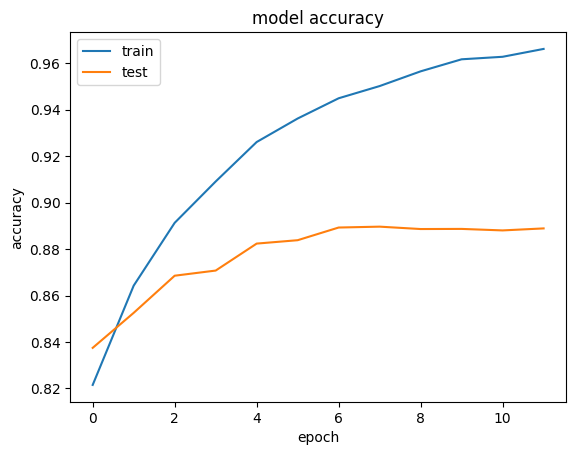

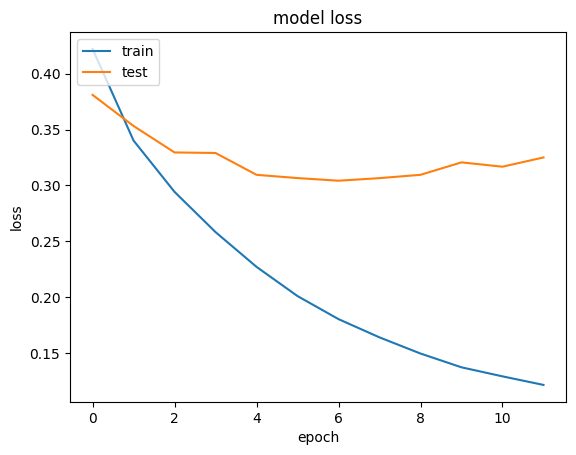

In [ ]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()